<a href="https://colab.research.google.com/github/dctime/minecraft-texture-generation/blob/main/learn_how_to_use_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Download Stuff

In [1]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install matplotlib
!pip install ipywidgets

In [2]:
import tensorflow as tf
try:
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
except:
  print("no gpu")

Found GPU at: /device:GPU:0


In [3]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [4]:
ds = tfds.load('fashion_mnist', split = 'train')

In [5]:
print(ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


2. Visualize it

In [6]:
import numpy as np

In [7]:
dataiterator = ds.as_numpy_iterator()

In [8]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

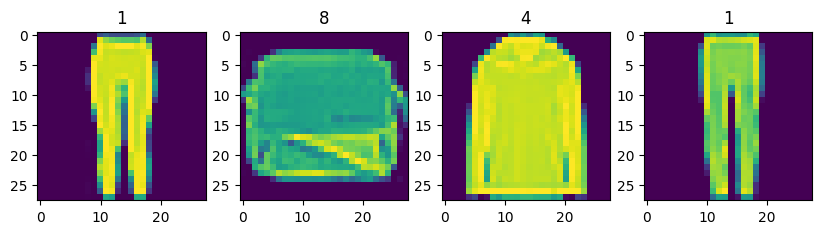

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
for idx in range(4):
  sample = dataiterator.next()
  # sample['image'] & sample['label']
  ax[idx].imshow(np.squeeze(sample['image']))
  ax[idx].title.set_text(sample['label'])

In [10]:
def scale_images(data_pair):
  image = data_pair['image']
  return image/255

In [11]:
ds = tfds.load('fashion_mnist', split = 'train')

ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(80000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [12]:
ds.as_numpy_iterator().next()

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

3. Build Models

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [14]:
def build_generator():
  model = Sequential()

  model.add(Dense((7*7*128), input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7, 7, 128)))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  model.add(Conv2D(1, 5, padding='same', activation='sigmoid'))


  return model

In [15]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 4s 4s/step


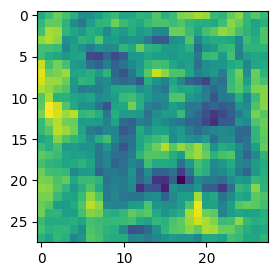

In [16]:
output = generator.predict(np.random.randn(1, 128, 1))
fig, ax = plt.subplots(ncols=1, figsize=(3,3))
ax.imshow(np.squeeze(output[0]))

In [17]:
def build_discriminator():
  model = Sequential()

  model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(64, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(128, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Conv2D(256, 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [18]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [19]:
discriminator.predict(output)

1/1 [==============================] - 0s 298ms/step


array([[0.4916148]], dtype=float32)

3. Train

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [21]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [22]:
from tensorflow.keras.models import Model

class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    super().__init__(*args, **kwargs)


    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    super().compile(*args, **kwargs)

    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

    self.g_opt.build(self.generator.trainable_variables)
    self.d_opt.build(self.discriminator.trainable_variables)

  # batch size 128
  def train_step(self, batch):
    real_img = batch
    fake_img = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # train discriminator
    with tf.GradientTape() as d_tape:
      yhat_real = self.discriminator(real_img, training=True)
      yhat_fake = self.discriminator(fake_img, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0) # data

      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0) # label

      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real)) # 0 + (0 - 0.15)
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake)) # 1 - (0 - 0.15)

      y_realfake += tf.concat([noise_real, noise_fake], axis=0) # real label

      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    d_gradient = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

    # train generator
    with tf.GradientTape() as g_tape:
      gen_img = self.generator(tf.random.normal((128, 128, 1)), training=True)
      predicted_label = self.discriminator(gen_img, training=False)
      total_g_loss = self.g_loss(tf.zeros_like(predicted_label), predicted_label)

    g_gradient = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

    return {'d_loss': total_d_loss, 'g_loss': total_g_loss}






In [23]:
model = FashionGAN(build_generator(), build_discriminator())
model.compile(g_opt, d_opt, g_loss, d_loss)

In [24]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128): # latent_dim: seed length
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255 # turn it back to normal images
    generated_images.numpy()
    for i in range(self.num_img): # loop from index 0 to num_img-1
      image = array_to_img(generated_images[i])
      image.save(os.path.join('images_2', f'generated_images_{epoch}_{i}.png'))


In [25]:
train = model.fit(ds, epochs=50, callbacks=[ModelMonitor()])

Epoch 1/50
469/469 [==============================] - 83s 154ms/step - d_loss: 0.5409 - g_loss: 1.1425
Epoch 2/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.2977 - g_loss: 6.1754
Epoch 3/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.2930 - g_loss: 3.3044
Epoch 4/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.5206 - g_loss: 1.4052
Epoch 5/50
469/469 [==============================] - 72s 153ms/step - d_loss: 0.5189 - g_loss: 0.3692
Epoch 6/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.7196 - g_loss: 0.3544
Epoch 7/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.6857 - g_loss: 0.5895
Epoch 8/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.6891 - g_loss: 0.5782
Epoch 9/50
469/469 [==============================] - 71s 152ms/step - d_loss: 0.7014 - g_loss: 0.6111
Epoch 10/50
469/469 [==============================] - 71s 152ms/step - d

In [26]:
print(train)